# Dataset shift

This notebook shows some examples of dataset shift and concept drift.

In the case of Dataset shift there is a distribution change between the training and the test/deployment in a way that

$$p(Y,X)_{training} \neq p(Y,X)_{test}$$

Similarly, concept drift is applied into temporal data in such a way that at two different times $i,j \in \{0,...,T\}$

$$p(Y,X)_{t_i} \neq p(Y,X)_{t_j}$$

with $i \neq j$ for some $i$ and $j$.

The following is a brief explanation of the types of Concept drift extracted from [1]

- Real concept drift (aka concept shift [Salganicoff 1997] and conditional change [Gao et al. 2007])  (p(y|X) changes with or without change in p(X)
- Virtual drift (aka temporary drift [Lazarescu et al. 2004], sampling shift [Salganicoff 1997], and feature change [Gao et al. 2007]) p(X) changes but not p(y|X).
- Different interpretations of Virtual drift: [Widmer and Kubat 1993] incomplete data representation, [Tsymbal 2004] changes in data distribution leading to changes in the decision boundary, [Delany et al. 2005] a drift that does not affect the target concept, 


[1] J. Gama, I. Žliobaitundefined, A. Bifet, M. Pechenizkiy, and A. Bouchachia, “A Survey on Concept Drift Adaptation,” ACM Comput. Surv., vol. 46, no. 4, Mar. 2014, doi: 10.1145/2523813.

In the following examples we will generate data from two classes, each one from a Gaussian Mixture model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
from scipy.stats import norm, multinomial

plt.style.use('seaborn-whitegrid')
#plt.style.use('ggplot')

class Mixture(object):
    def __init__(self, generator_list, prior_list=None):
        self.generator_list = generator_list
        if prior_list is None:
            prior_list = np.ones(len(generator_list))/len(generator_list)
        self.prior_list = prior_list
        self.multinomial = multinomial(n=1, p=prior_list)
        self.n_components = len(generator_list)
        
    def rvs(self, size=1):
        samples = np.empty(size)
        components_idx = np.argmax(self.multinomial.rvs(size), axis=1)
        component_counts = np.unique(components_idx, return_counts=True)
        for c, count in zip(*component_counts):
            samples[components_idx == c] = self.generator_list[c].rvs(count)
        return samples
    
    def pdf(self, x):
        pdf = np.zeros(len(x))
        for c in range(self.n_components):
            pdf += self.prior_list[c]*self.generator_list[c].pdf(x)
        return pdf

### $p(x|y=1)$

The first class has the following distribution

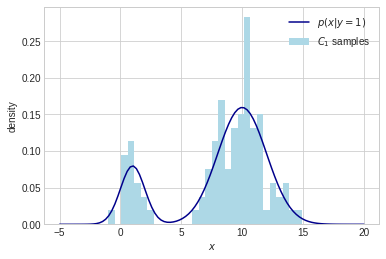

In [2]:
x = np.linspace(-5, 20, 100)
mixture_c1 = Mixture([norm(loc=1, scale=1), 
                      norm(loc=10, scale=2)],
                     prior_list=[0.2, 0.8])
samples = mixture_c1.rvs(100)
plt.hist(samples, bins=30, density=True, color='lightblue', label='$C_1$ samples')
plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $p(x|y=2)$

and the second class the following distribution

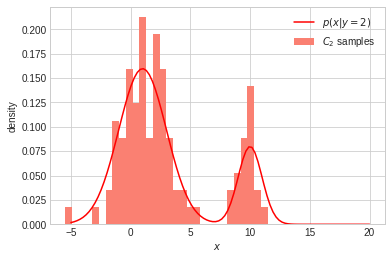

In [3]:
mixture_c2 = Mixture([norm(loc=1, scale=2), 
                      norm(loc=10, scale=1)],
                     prior_list=[0.8, 0.2])
samples = mixture_c2.rvs(100)
plt.hist(samples, bins=30, density=True, color='salmon', label='$C_2$ samples')
plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $P(y=1|x)$

The following is the corresponding posterior probability for class 1

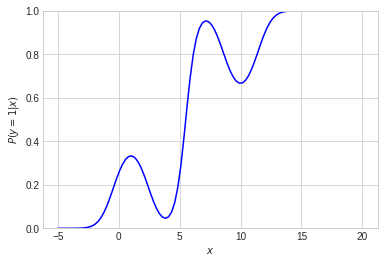

In [4]:
p_c1_g_x = mixture_c1.pdf(x)/(mixture_c1.pdf(x) + mixture_c2.pdf(x))
plt.plot(x, p_c1_g_x, color='blue')
plt.ylim(0, 1)
plt.ylabel('$P(y=1|x)$')
plt.xlabel('$x$');

### $p(x)$

And this is the overall distribution of $X$

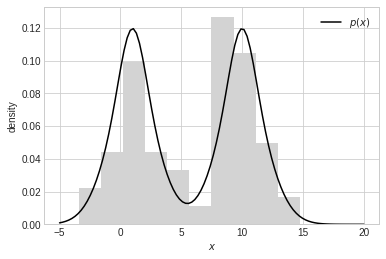

In [5]:
full_mixture = Mixture([mixture_c1, mixture_c2], prior_list=[0.5, 0.5])
plt.plot(x, full_mixture.pdf(x), color='black', label='$p(x)$')
plt.hist(full_mixture.rvs(100), density=True, color='lightgrey')
#plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
#plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

# Concept drift with no change on $p(x)$

We show an example of concept drift where $P(y|x)$ changes but not $p(x)$. We do that by just swaping both generator methods, considering that now class 1 has the previous distribution of class 2 and vice versa.

This concept drift can not be detected only by looking at $p(x)$, thus it requires new labels which can be used to see the concept drift of $p(x|y)$.

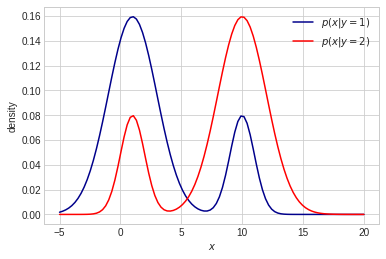

In [6]:
mixture_aux = mixture_c1
mixture_c1 = mixture_c2
mixture_c2 = mixture_aux

new_full_mixture = Mixture([mixture_c1, mixture_c2])
plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $p(x)_{training} = p(x)_{test}$

With the previous changes in the distribution of the classes the distribution of $p(x)$ does not change

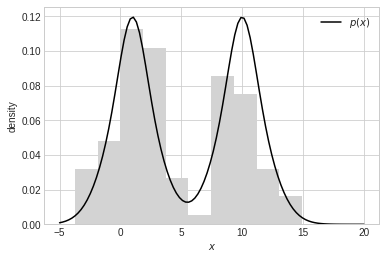

In [7]:
new_full_mixture = Mixture([mixture_c1, mixture_c2])
plt.plot(x, new_full_mixture.pdf(x), color='black', label='$p(x)$')
plt.hist(new_full_mixture.rvs(100), density=True, color='lightgrey')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $p(y=1|x)_{training} \neq p(y=1|x)_{test}$

However, the posterior probabilities change

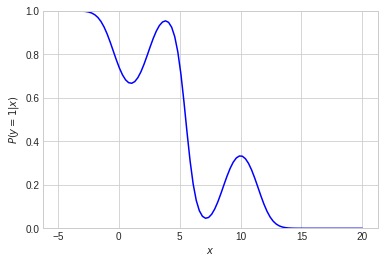

In [8]:
p_c1_g_x = mixture_c1.pdf(x)/(mixture_c1.pdf(x) + mixture_c2.pdf(x))
plt.plot(x, p_c1_g_x, color='blue')
plt.ylim(0, 1)
plt.ylabel('$P(y=1|x)$')
plt.xlabel('$x$');

# Concept drift with change in both $p(x)$ and $p(y|x)$

We show an example of concept drift where $P(y|x)$ and $p(x)$ change.

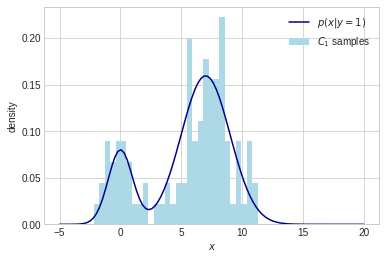

In [9]:
x = np.linspace(-5, 20, 100)
mixture_c1 = Mixture([norm(loc=0, scale=1), 
                      norm(loc=7, scale=2)],
                     prior_list=[0.2, 0.8])
samples = mixture_c1.rvs(100)
plt.hist(samples, bins=30, density=True, color='lightblue', label='$C_1$ samples')
plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

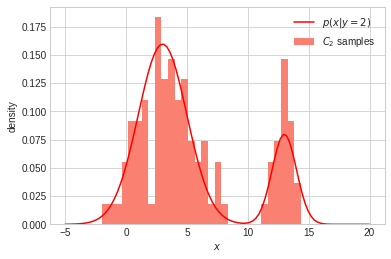

In [10]:
mixture_c2 = Mixture([norm(loc=3, scale=2), 
                      norm(loc=13, scale=1)],
                     prior_list=[0.8, 0.2])
samples = mixture_c2.rvs(100)
plt.hist(samples, bins=30, density=True, color='salmon', label='$C_2$ samples')
plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $p(x)$

And this is the overall distribution of $X$

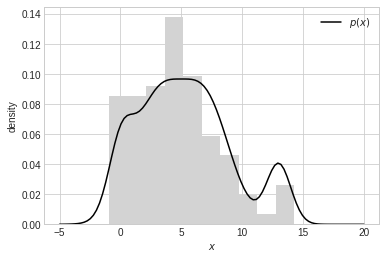

In [11]:
full_mixture = Mixture([mixture_c1, mixture_c2], prior_list=[0.5, 0.5])
plt.plot(x, full_mixture.pdf(x), color='black', label='$p(x)$')
plt.hist(full_mixture.rvs(100), density=True, color='lightgrey')
#plt.plot(x, mixture_c1.pdf(x), color='darkblue', label='$p(x|y=1)$')
#plt.plot(x, mixture_c2.pdf(x), color='red', label='$p(x|y=2)$')
plt.legend()
plt.ylabel('density')
plt.xlabel('$x$');

### $P(y=1|x)$

The following is the corresponding posterior probability for class 1

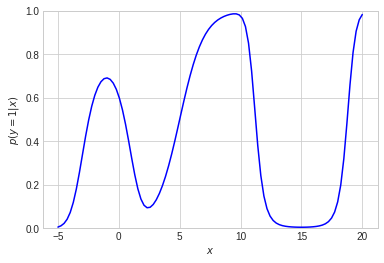

In [12]:
p_c1_g_x = mixture_c1.pdf(x)/(mixture_c1.pdf(x) + mixture_c2.pdf(x))
plt.plot(x, p_c1_g_x, color='blue')
plt.ylim(0, 1)
plt.ylabel('$p(y=1|x)$')
plt.xlabel('$x$');